#### python kernel : 3.7.13

In [7]:
import pandas as pd
import pystan   #pip install cython, pip install "pystan<2.18"
(pystan.__version__)
from fbprophet import Prophet    #pip install fbprophet
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pystan'

In [4]:
#data 불러오기
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [40]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
print(data.info(),data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB
None 기준시각           0
직전 15분 사용전력    0
dtype: int64


#이상치 처리(이전 값으로 대체)

In [42]:
# 5100 이하값들은 이전 값들로 대체
import numpy as np
data.loc[(data['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data.isna().sum()


기준시각              0
직전 15분 사용전력    1884
dtype: int64

In [45]:
data=data.fillna(method='ffill')
data.isna().sum()


기준시각           0
직전 15분 사용전력    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


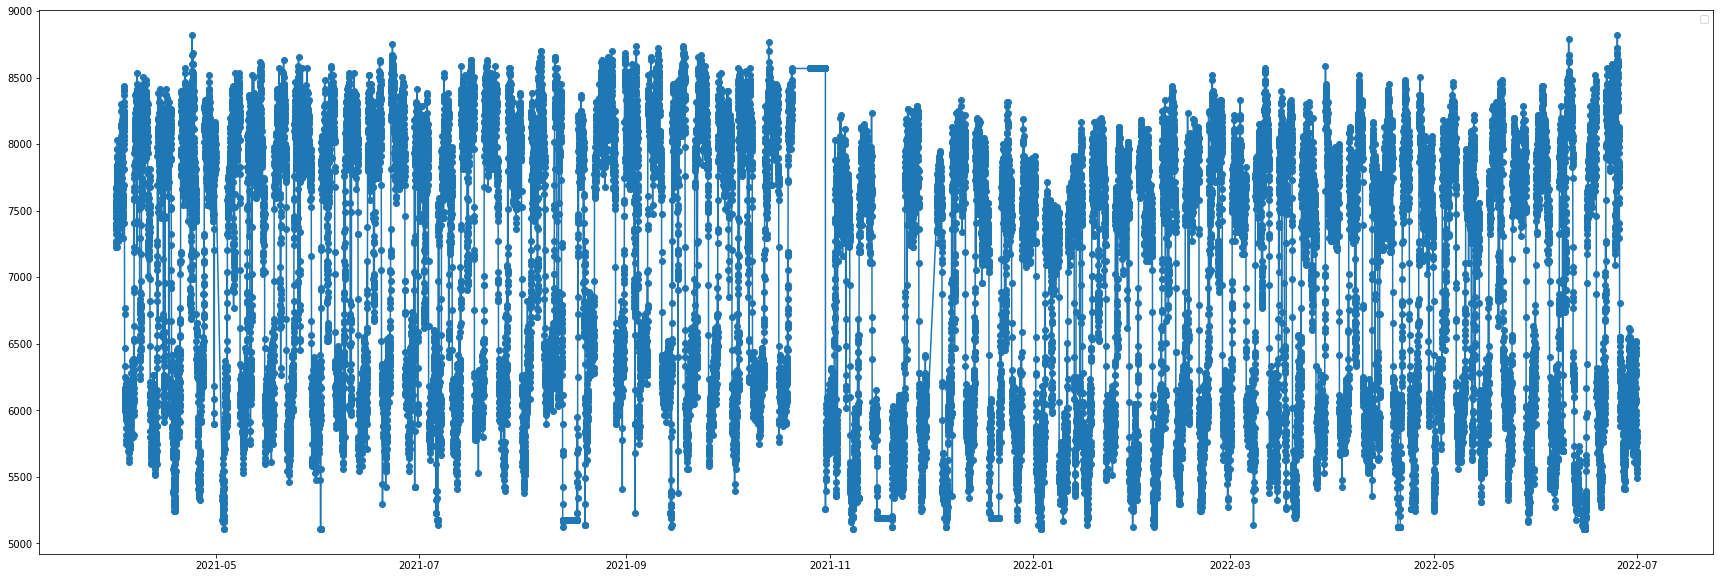

In [47]:
#plot
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data['기준시각'],data['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [50]:
#lag, diff feature 생성
NP.gen_feature_lag(data,'직전 15분 사용전력','l_1',1)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_2',2)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_3',3)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_4',4)
NP.gen_feature_lag(data,'직전 15분 사용전력','l_5',5)


NP.gen_feature_diff(data,'직전 15분 사용전력','d_1',1)
NP.gen_feature_diff(data,'직전 15분 사용전력','d_2',2)


,기준시각,직전 15분 사용전력,l_1,l_2,l_3,l_4,l_5,d_1,d_2
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,7224.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN
3,2021-04-01 00:45:00,7392.0,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4
4,2021-04-01 01:00:00,7576.8,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6
...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0
42762,2022-06-30 23:00:00,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6
42763,2022-06-30 23:15:00,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0
42764,2022-06-30 23:30:00,5527.2,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4


In [51]:
def train_test_split(data_t,train_cut_date,val_cut_date,end_time): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)& (data_t['기준시각'] < end_time )] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-30','2022-06-30','2022-06-30 23:00:00')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [ ]:
df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
# df_val.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

In [ ]:
#tunning
import itertools
import numpy as np
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

cutoffs = pd.to_datetime(['2021-05-15', '2021-08-15', '2022-02-15'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
  m = Prophet(changepoint_prior_scale= 0.001, seasonality_prior_scale=1.0) # Default growth='linear'

In [64]:
m.fit(df_train)
future = m.make_future_dataframe(periods=4*24,freq = '15min')
forecast=m.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(96)

In [ ]:
result_df=pd.merge(df_test,forecast,how='left',on='ds')


In [ ]:
#  fig1, ax = plt.subplots(figsize=(14, 10)) 
fig, ax = plt.subplots(figsize=(30, 10)) 
m.plot(forecast, xlabel="Date", ylabel="elec", ax=ax)
ax.set_title("moorim_demand", fontsize=28, fontweight="bold")


In [ ]:
def predict_graph(test,prediction) : #train,
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)   
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(result_df['y'],result_df['yhat'])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(dd['y_x'], dd['yhat1'])

In [18]:
# # model save to disk
# import pickle

# filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try1.sav'
# pickle.dump(model, open(filename, 'wb'))